<딥러닝 파이토치 교과서> ch2. 4 p.69 ~ 87

In [42]:
pip install torch torchvision

In [43]:
pip install --upgrade matplotlib seaborn scikit-learn

In [44]:
pip install numpy==1.26.4 --force-reinstall

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [45]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2.4 파이토치 코드 맛보기

In [47]:
import pandas as pd

dataset = pd.read_csv('/content/drive/MyDrive/ESAA_OB/Dataset/car_evaluation.csv')
dataset.head()

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


<Axes: ylabel='count'>

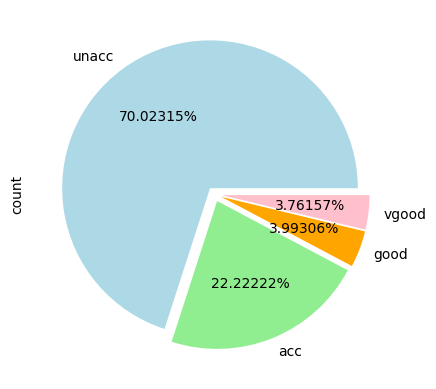

In [48]:
# 데이터셋 분포 파악
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 6
fig_size[0] = 8
plt.rcParams['figure.figsize'] = fig_size
dataset.output.value_counts().plot(kind='pie', autopct='%0.05f%%',
colors = ['lightblue', 'lightgreen', 'orange', 'pink'], explode=(0.05, 0.05, 0.05, 0.05))

대부분의 자동차(70%)는 허용 불가능한 상태, 20%만 허용 가능한 수준.

## 전처리
(1) 데이터 타입 변환:  

   범주형 데이터 -> dataset[category] : `by astype()`
   
   -> 넘파이 배열(Numpy array) : by `.cat.codes.values`

   -> 텐서(Tensor) : by `torch` module

(2) `np.stack()`을 이용해 두 개 이상의 넘파이 객체 합치기  

In [49]:
# 데이터를 범주형 타입으로 변환
categorical_columns = ['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety']

for category in categorical_columns:
  dataset[category] = dataset[category].astype('category')

# 범주형 타입을 숫자(넘파이)배열로 변환
price = dataset['price'].cat.codes.values # ...(1)
maint = dataset['maint'].cat.codes.values
doors = dataset['doors'].cat.codes.values
persons = dataset['persons'].cat.codes.values
lug_capacity = dataset['lug_capacity'].cat.codes.values
safety = dataset['safety'].cat.codes.values

categorical_data = np.stack([price, maint, doors, persons, lug_capacity, safety], 1) #...(2)
categorical_data[:10]

array([[3, 3, 0, 0, 2, 1],
       [3, 3, 0, 0, 2, 2],
       [3, 3, 0, 0, 2, 0],
       [3, 3, 0, 0, 1, 1],
       [3, 3, 0, 0, 1, 2],
       [3, 3, 0, 0, 1, 0],
       [3, 3, 0, 0, 0, 1],
       [3, 3, 0, 0, 0, 2],
       [3, 3, 0, 0, 0, 0],
       [3, 3, 0, 1, 2, 1]], dtype=int8)

In [50]:
# 배열을 텐서로 변환
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
categorical_data[:10]

tensor([[3, 3, 0, 0, 2, 1],
        [3, 3, 0, 0, 2, 2],
        [3, 3, 0, 0, 2, 0],
        [3, 3, 0, 0, 1, 1],
        [3, 3, 0, 0, 1, 2],
        [3, 3, 0, 0, 1, 0],
        [3, 3, 0, 0, 0, 1],
        [3, 3, 0, 0, 0, 2],
        [3, 3, 0, 0, 0, 0],
        [3, 3, 0, 1, 2, 1]])

In [51]:
# 레이블로 사용할 칼럼을 텐서로 변환
outputs = pd.get_dummies(dataset.output)
outputs = outputs.values
outputs = torch.tensor(outputs).flatten() # 1차원 텐서로 변환

print(categorical_data.shape)
print(outputs.shape)

torch.Size([1728, 6])
torch.Size([6912])


*`ravel(), rehshape(), flatten()`은 텐서의 차원을 바꿀 때 사용

## 워드 인베딩 (Word Embedding, 벡터화)
- 높은 차원의 임베딩일수록 단어 간의 세부적인 관계를 잘 파악할 수 있음.
- 보통 임베팅 크기(벡터 차원) = (칼럼의 고유 값 수) / 2


In [52]:
# 범주형 칼럼을 N차원으로 변환
categorical_column_sizes = [len(dataset[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[(4, 2), (4, 2), (4, 2), (3, 2), (3, 2), (3, 2)]


In [53]:
# 데이터셋 분리
total_records = 1728
test_records = int(total_records * .2) # 전체 데이터 중 20%를 테스트 용도로 사용

categorical_train_data = categorical_data[:total_records - test_records]
categorical_test_data = categorical_data[total_records - test_records:total_records]
train_outputs = outputs[:total_records - test_records]
test_outputs = outputs[total_records - test_records : total_records]

In [54]:
# 데이터셋 분리 확인
print(len(categorical_train_data))
print(len(train_outputs))
print(len(categorical_test_data))
print(len(test_outputs))

1383
1383
345
345


## 모델의 네트워크 생성

In [60]:
# 모델의 네트워크 생성
class Model(nn.Module): #...(1)
    def __init__(self, embedding_size, output_size, layers, p=0.4):  #...(2)
        super().__init__()  #...(3)
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for
                                         ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols  # 입력층의 크기를 찾기 위해 범주형 칼럼 개수를 input_size 변수에 저장

        for i in layers:  #...(4)
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace = True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))
        # 신경망의 모든 계층이 순차적으로 실행되도록 모든 계층에 대한 목록(all_layers)을 nn.Sequential 클래스로 전달
        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical):  #...(5)
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:, i]))

        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)
        x = self.layers(x)
        return x


(1) 클래스(class) 형태로 구현된 모델은 nn.Module을 상속받음.

(2) `__init__()`: 모델에서 사용될 파라미터와 신경망을 초기화하기 위한 용도. 객체가 생성될 때 자동으로 호출.

    `def __init__(self, embedding_size, output_size, layers, p=0.4)`
   - `self`: 자기 자신을 의미


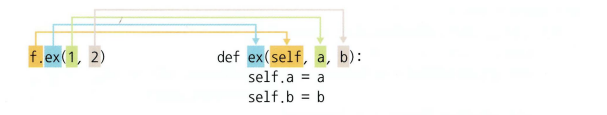

- `embedding_size`: 범주형 칼럼의 임베딩 크기
- `output_size`: 출력층의 크기
- `layers`: 모든 계층에 대한 목록
- `p`: 드롭아웃(디폴트 0.5)

(3) `super().__init__()`은 부모 클래스(`nn.Module`)에 접근할 때 사용.

(4) 모델의 네트워크 계층을 구축하기 위해 for문을 이용해 각 계층을 `all_layers` 목록에 추가
- Linear: 선형 계층은 입력 데이터에 선형 변환을 진행한 결과. 입력 * 가중치 + 바이어스


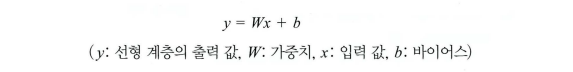

- ReLU: 활성화 함수
- BatchNorm1d: 배치 정규화 용도로 사용
- Dropout: 과적합 방지에 사용

(5) `forward()` 함수는 학습 데이터를 입력받아서 연산을 진행.

In [61]:
# Model 클래스의 객체 생성
model = Model(categorical_embedding_sizes, 4, [200, 100, 50], p=0.4)
print(model)

Model(
  (all_embeddings): ModuleList(
    (0-2): 3 x Embedding(4, 2)
    (3-5): 3 x Embedding(3, 2)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
  )
)


-> 모델에 대한 구조(네트워크)를 보여줌.

## 손실함수와 옵티마이저 정의
- 손실함수: cross-entropy 사용
- Optimizer: Adam 사용

In [62]:
# 모델의 파라미터 정의
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [63]:
# 파이토치는 GPU에 최적화된 딥러닝 프레임워크. CPU/GPU 사용 지정
if torch.cuda.is_available():
  device = torch.device('cude') # GPU가 있다면 GPU를 사용
else:
  device = torch.device('cpu') # 없다면 CPU를 사용

## 모델 학습

In [64]:
epochs = 500
aggregated_losses = []
train_outputs = train_outputs.to(device=device, dtype=torch.int64)

# for문을 500회 반복, 각 반복마다 손실함수가 오차를 계산.
for i in range(epochs):
  i += 1
  y_pred = model(categorical_train_data).to(device)
  single_loss = loss_function(y_pred, train_outputs)
  aggregated_losses.append(single_loss)

  if i%25 == 1:
    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

  optimizer.zero_grad()
  single_loss.backward() # 가중치를 업데이터하기 위해 손실함수의 backward() 메서드 호출
  optimizer.step() # 옵티마이저 함수의 step() 메서드를 이용하여 기울기 업데이트

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}') # 오차가 25 에포크마다 출력

epoch:   1 loss: 1.50614023
epoch:  26 loss: 1.32318246
epoch:  51 loss: 1.23384607
epoch:  76 loss: 1.13553548
epoch: 101 loss: 1.03831661
epoch: 126 loss: 0.89005280
epoch: 151 loss: 0.79280353
epoch: 176 loss: 0.71814406
epoch: 201 loss: 0.67730188
epoch: 226 loss: 0.64884472
epoch: 251 loss: 0.62277550
epoch: 276 loss: 0.60079890
epoch: 301 loss: 0.60047126
epoch: 326 loss: 0.58975184
epoch: 351 loss: 0.57966977
epoch: 376 loss: 0.58412713
epoch: 401 loss: 0.58263451
epoch: 426 loss: 0.57533443
epoch: 451 loss: 0.56516767
epoch: 476 loss: 0.57094479
epoch: 500 loss: 0.5641663671


-> 25 에포크마다 출력된 오차 정보 보여줌.

## 테스트 데이터셋으로 예측 진행

In [65]:
# 테스트 데이터셋으로 모델 예측
test_outputs = test_outputs.to(device=device, dtype=torch.int64)
with torch.no_grad():
  y_val = model(categorical_test_data)
  loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')

Loss: 0.57455963


-> 테스트 용도의 데이터셋에 대한 손실값.

-> 훈련 데이터셋에서 도출된 손실값과 비슷하므로 과적합은 발생하지 않았다고 판단.

In [66]:
# 모델의 예측 확인
print(y_val[:5])

tensor([[ 1.9186,  1.1002, -2.0354, -2.2169],
        [ 3.5761,  2.1606, -5.0931, -5.3685],
        [ 2.4815,  2.2125, -5.1940, -5.3363],
        [ 1.6262,  0.8853, -4.4906, -4.0086],
        [ 1.5674,  0.9788, -3.3813, -3.3204]])


-> 앞에서 모델 네트워크의 output_size에 4로 지정했기 때문에 예측에도 네 개의 값이 포함됨.

In [67]:
# 목록에서 가장 큰 값을 갖는 인덱스 확인
y_val = np.argmax(y_val, axis=1)
print(y_val[:5])

tensor([0, 0, 0, 0, 0])


-> 인덱스 0값이 인덱스 1인 값보다 큼.

In [68]:
# 테스트 데이터셋을 이용한 정확도 확인
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(test_outputs, y_val))
print(classification_report(test_outputs, y_val))
print(accuracy_score(test_outputs, y_val))

[[257   2]
 [ 86   0]]
              precision    recall  f1-score   support

           0       0.75      0.99      0.85       259
           1       0.00      0.00      0.00        86

    accuracy                           0.74       345
   macro avg       0.37      0.50      0.43       345
weighted avg       0.56      0.74      0.64       345

0.744927536231884


-> 신경망에서 필요한 모든 파라미터를 무작위로 선택했다는 것을 감안했을 때 75%의 정확도는 나쁘지 않음.

-> 파라미터(훈련/테스트 데이터셋 분할, 은닉츨 개수 및 크기)를 변경하면서 더 나은 성능을 찾아보는 것도 학습에 도움이 될 것임.

# 딥러닝 분류 모델의 성능 평가 지표
####[용어]
- True Positive: 실제값 1, 모델 예측도 1
- True Negative: 실제값 0, 모델 예측도 0
- False Positive: 실제값 0, 모델 예측 1. $Type 1$ 오류.  
- False Negative: 실제값 1, 모델 예측 0. $Type 2$ 오류.

####[성능 지표]
- 정확도: 전체 예측 건수에서 정답을 맞힌 건수의 비율

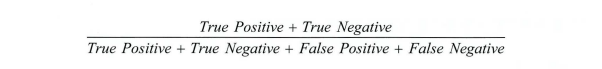

- 재현율: 실제 정답이 1일때 모델도 1로 예측한 비율.
   - 처음부터 데이터가 1일 확률이 적을 때 사용하면 좋음.

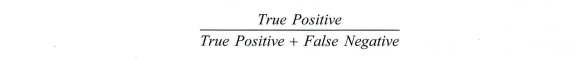

- 정밀도: 모델이 1이라고 예측한 것 중에서 실제로 정답이 1인 비율

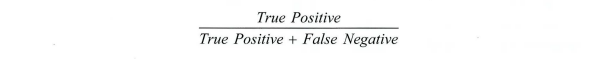

- F1 스코어: 정밀도와 재현율의 trade-off 문제를 해결하기 위해 둘의 조화 평균(harmonic mean)을 이용한 것.

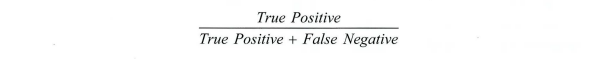